# k-Means on Customers: Age vs Income
This notebook reads the provided dataset, plots Income vs Age, runs manual k-Means for k=2 and k=3 for 4 iterations, and prints marketing-friendly prompts to describe each cluster.

In [1]:
# Save the CSV and load it
import pandas as pd, numpy as np, matplotlib.pyplot as plt
csv_path = "customers.csv"
df = pd.read_csv(csv_path)
df.head()

,CustomerID,Age,Income_k$,SpendingScore
0,1,16,22,85
1,2,17,25,78
2,3,19,28,72
3,4,22,32,88
4,5,24,35,81


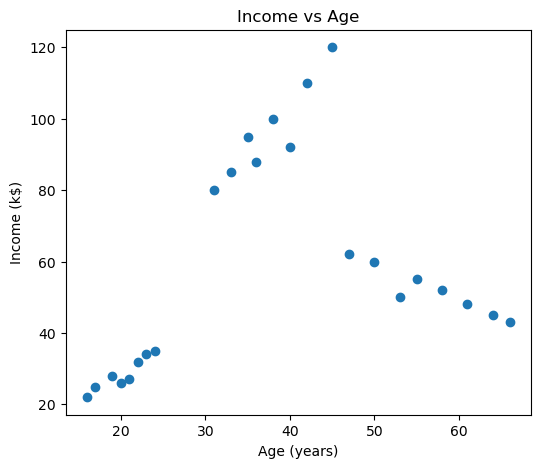

In [2]:
# Plot Income vs Age
plt.figure(figsize=(6,5))
plt.scatter(df["Age"], df["Income_k$"])
plt.xlabel("Age (years)")
plt.ylabel("Income (k$)")
plt.title("Income vs Age")
plt.show()

In [3]:
# Manual K-Means with plotting for a fixed number of iterations
import numpy as np
import matplotlib.pyplot as plt

def run_kmeans_plot(df, k=2, iters=4, seed=7, feature_cols=("Age","Income_k$")):
    X = df.loc[:, feature_cols].to_numpy(dtype=float)
    rng = np.random.default_rng(seed)
    mins, maxs = X.min(axis=0), X.max(axis=0)
    centers = rng.uniform(mins, maxs, size=(k, X.shape[1]))

    centroid_markers = ["X","D","P","s","^","v","<",">"]

    for it in range(1, iters+1):
        dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
        labels = dists.argmin(axis=1)

        plt.figure(figsize=(6,5))
        for c in range(k):
            idx = labels == c
            plt.scatter(X[idx,0], X[idx,1], label=f"Cluster {c+1}")
        for c in range(k):
            mk = centroid_markers[c % len(centroid_markers)]
            plt.scatter(centers[c,0], centers[c,1], marker=mk, s=180, edgecolor="black", linewidths=1.0, label=f"C{c+1} center")
        plt.xlabel(feature_cols[0]); plt.ylabel(feature_cols[1])
        plt.title(f"K-Means (k={k}) — iteration {it}")
        plt.legend(); plt.show()

        # update centers
        new_centers = centers.copy()
        for c in range(k):
            pts = X[labels==c]
            if len(pts) > 0:
                new_centers[c] = pts.mean(axis=0)
        centers = new_centers
    return labels, centers

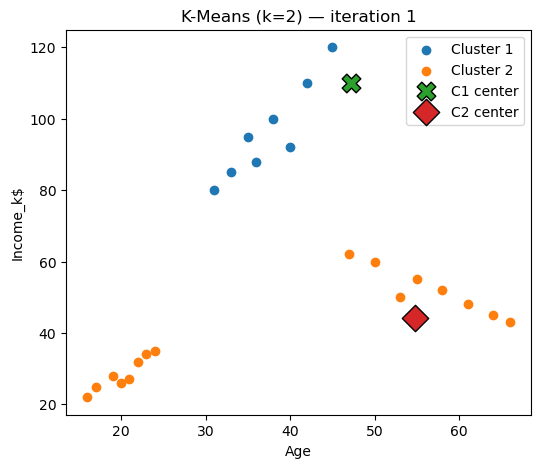

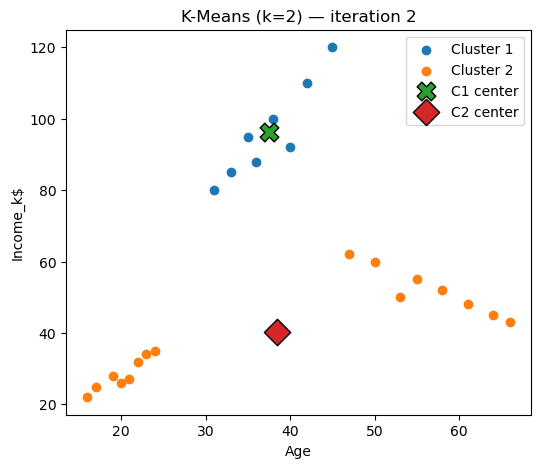

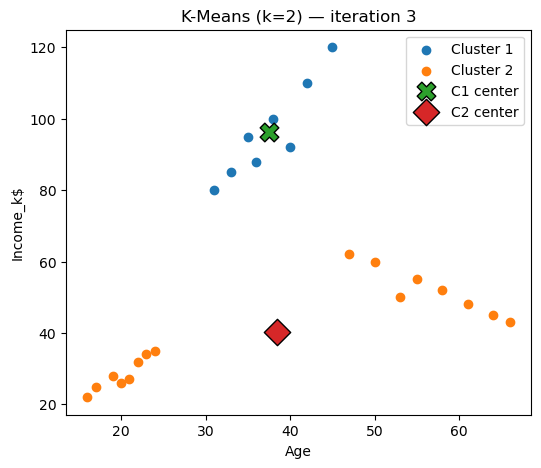

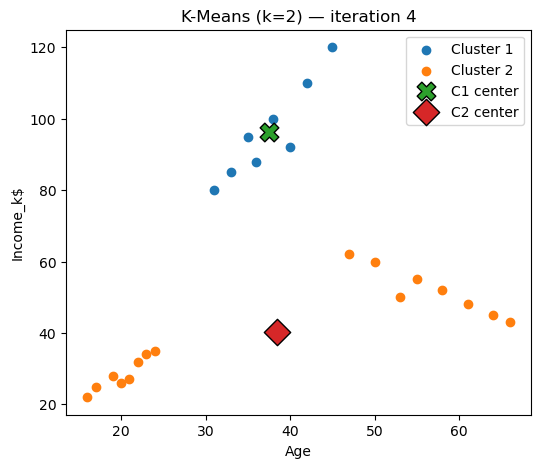

In [4]:
# Run for k=2 (4 iterations)
labels_k2, centers_k2 = run_kmeans_plot(df, k=2, iters=4, seed=7, feature_cols=("Age","Income_k$"))

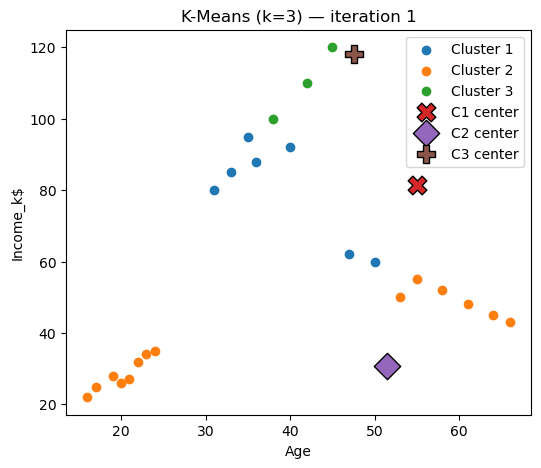

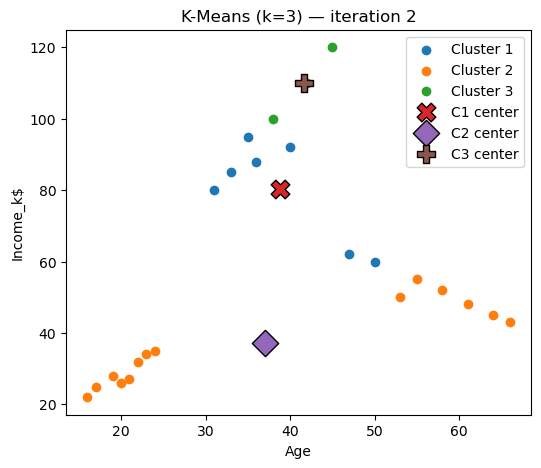

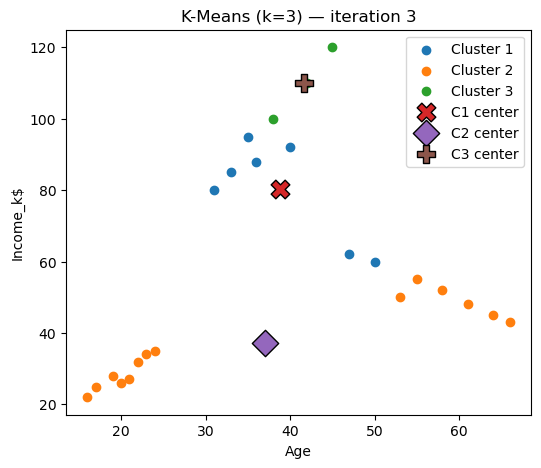

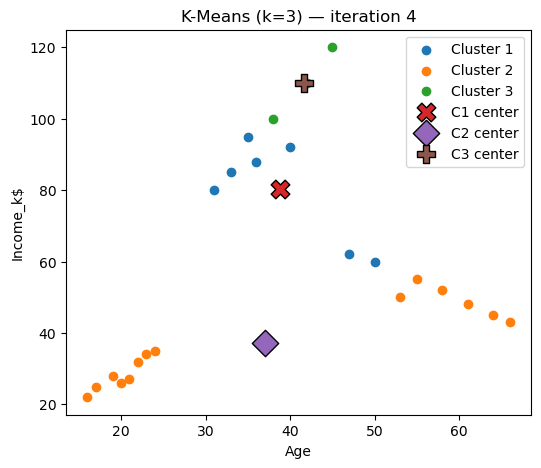

In [5]:
# Run for k=3 (4 iterations)
labels_k3, centers_k3 = run_kmeans_plot(df, k=3, iters=4, seed=21, feature_cols=("Age","Income_k$"))

In [6]:
# Build marketing-style prompts describing each cluster using Age, Income, and SpendingScore
def cluster_prompts(df, labels, k, feature_cols=("Age","Income_k$","SpendingScore")):
    prompts = []
    for c in range(k):
        sub = df.loc[labels==c, list(feature_cols)]
        if len(sub)==0:
            prompts.append(f"Cluster {c+1}: No members in this cluster.")
            continue
        age_mean = round(sub["Age"].mean(),1)
        age_rng = (int(sub["Age"].min()), int(sub["Age"].max()))
        inc_mean = round(sub["Income_k$"].mean(),1)
        inc_rng = (int(sub["Income_k$"].min()), int(sub["Income_k$"].max()))
        sp_mean = round(sub["SpendingScore"].mean(),1)
        sp_rng = (int(sub["SpendingScore"].min()), int(sub["SpendingScore"].max()))
        prompt = (
            f"You are a marketing analyst. Explain Cluster {c+1} clearly and briefly:\n"
            f"- Size: {len(sub)} customers\n"
            f"- Typical age: ~{age_mean} (range {age_rng[0]}–{age_rng[1]})\n"
            f"- Typical income: ~{inc_mean}k$ (range {inc_rng[0]}–{inc_rng[1]}k$)\n"
            f"- Typical spending score: ~{sp_mean} (range {sp_rng[0]}–{sp_rng[1]})\n"
            f"Then suggest 2–3 marketing actions (channels, offers, messaging) tailored to this group."
        )
        prompts.append(prompt)
    return prompts

print("--- Prompts for k=2 ---")
for p in cluster_prompts(df, labels_k2, k=2):
    print(p, "\n")

print("--- Prompts for k=3 ---")
for p in cluster_prompts(df, labels_k3, k=3):
    print(p, "\n")

--- Prompts for k=2 ---
You are a marketing analyst. Explain Cluster 1 clearly and briefly:
- Size: 8 customers
- Typical age: ~37.5 (range 31–45)
- Typical income: ~96.2k$ (range 80–120k$)
- Typical spending score: ~59.0 (range 52–65)
Then suggest 2–3 marketing actions (channels, offers, messaging) tailored to this group. 

You are a marketing analyst. Explain Cluster 2 clearly and briefly:
- Size: 16 customers
- Typical age: ~38.5 (range 16–66)
- Typical income: ~40.2k$ (range 22–62k$)
- Typical spending score: ~51.8 (range 15–90)
Then suggest 2–3 marketing actions (channels, offers, messaging) tailored to this group. 

--- Prompts for k=3 ---
You are a marketing analyst. Explain Cluster 1 clearly and briefly:
- Size: 7 customers
- Typical age: ~38.9 (range 31–50)
- Typical income: ~80.3k$ (range 60–95k$)
- Typical spending score: ~50.0 (range 28–63)
Then suggest 2–3 marketing actions (channels, offers, messaging) tailored to this group. 

You are a marketing analyst. Explain Cluster

## Better prompts 

In [11]:
# Build marketing-style prompts that use per-cluster SUMMARY (no raw rows)
def cluster_prompts_with_summary(
    df,
    labels,
    k,
    feature_cols=("Age", "Income_k$", "SpendingScore"),
    round_to=1,
    income_suffix="k$"
):
    """
    Creates LLM-ready prompts per cluster using only summary stats:
      - size, mean, min, max for Age, Income_k$, SpendingScore
    Keeps the same 'TASKS' and 'RULES' style as your RAW ROWS template,
    but privacy-friendly (no individual rows).

    Parameters
    ----------
    df : pandas.DataFrame
    labels : array-like of shape (len(df),)
    k : int, number of clusters
    feature_cols : tuple/list of features to summarise
    round_to : int/None, rounding decimals for means
    income_suffix : str, suffix to append to Income (e.g., "k$", "$k", or "")
    """
    import pandas as pd

    prompts = []
    for c in range(k):
        sub = df.loc[labels == c, list(feature_cols)].copy()
        if len(sub) == 0:
            prompts.append(f"Cluster {c+1}: No members in this cluster.")
            continue

        # Compute stats
        age_mean = round(sub["Age"].mean(), round_to)
        age_min, age_max = int(sub["Age"].min()), int(sub["Age"].max())

        inc_mean = round(sub["Income_k$"].mean(), round_to)
        inc_min, inc_max = int(sub["Income_k$"].min()), int(sub["Income_k$"].max())

        sp_mean = round(sub["SpendingScore"].mean(), round_to)
        sp_min, sp_max = int(sub["SpendingScore"].min()), int(sub["SpendingScore"].max())

        # Build the summary block (mirrors your example)
        summary_block = (
            f"Explain Cluster {c+1} clearly and briefly:\n"
            f"- Size: {len(sub)} customers\n"
            f"- Typical age: ~{age_mean} (range {age_min}–{age_max})\n"
            f"- Typical income: ~{inc_mean}{income_suffix} (range {inc_min}–{inc_max}{income_suffix})\n"
            f"- Typical spending score: ~{sp_mean} (range {sp_min}–{sp_max})"
        )

        # Full prompt (same tone/structure as your RAW ROWS template)
        prompt = (
            f"You are a marketing analyst. Use the SUMMARY below (no raw rows) to describe this cluster.\n\n"
            f"SUMMARY:\n{summary_block}\n\n"
            f"TASKS\n"
            f"1) Give this cluster a short nickname (e.g., 'Young high spenders').\n"
            f"2) Describe the common traits you see from Age, Income_k$, and SpendingScore in simple words.\n"
            f"3) Suggest 2–3 marketing actions (channels, offers, messaging) tailored to this group.\n"
            f"4) Mention one ethical caveat (privacy/fairness/stereotyping).\n"
            f"RULES\n"
            f"- Base your explanation ONLY on the summary shown.\n"
            f"- Do not attempt to identify individuals.\n"
            f"- Keep it friendly and concise (120–180 words)."
        )
        prompts.append(prompt)

    return prompts


In [13]:
print("--- Prompts for k=2 ---")
for p in cluster_prompts_with_summary(df, labels_k2, k=2):
    print(p, "\n")

print("--- Prompts for k=3 ---")
for p in cluster_prompts_with_summary(df, labels_k3, k=3):
    print(p, "\n")


--- Prompts for k=2 ---
You are a marketing analyst. Use the SUMMARY below (no raw rows) to describe this cluster.

SUMMARY:
Explain Cluster 1 clearly and briefly:
- Size: 8 customers
- Typical age: ~37.5 (range 31–45)
- Typical income: ~96.2k$ (range 80–120k$)
- Typical spending score: ~59.0 (range 52–65)

TASKS
1) Give this cluster a short nickname (e.g., 'Young high spenders').
2) Describe the common traits you see from Age, Income_k$, and SpendingScore in simple words.
3) Suggest 2–3 marketing actions (channels, offers, messaging) tailored to this group.
4) Mention one ethical caveat (privacy/fairness/stereotyping).
RULES
- Base your explanation ONLY on the summary shown.
- Do not attempt to identify individuals.
- Keep it friendly and concise (120–180 words). 

You are a marketing analyst. Use the SUMMARY below (no raw rows) to describe this cluster.

SUMMARY:
Explain Cluster 2 clearly and briefly:
- Size: 16 customers
- Typical age: ~38.5 (range 16–66)
- Typical income: ~40.2k$ (

In [12]:
## Use raw data

In [9]:
# Build marketing-style prompts that INCLUDE PLAIN ROWS for each cluster
def cluster_prompts_with_rows(
    df,
    labels,
    k,
    expose_cols=("Age", "Income_k$", "SpendingScore"),
    max_rows=None,                # None = include all rows; set an int to cap
    random_state=0
):
    import pandas as pd

    prompts = []
    for c in range(k):
        sub = df.loc[labels == c, list(expose_cols)].copy()
        if len(sub) == 0:
            prompts.append(f"Cluster {c+1}: No members in this cluster.")
            continue

        # Optional cap to keep prompts manageable
        shown = sub
        if (max_rows is not None) and (len(sub) > max_rows):
            shown = sub.sample(n=max_rows, random_state=random_state)

        csv_text = shown.to_csv(index=False)

        prompt = (
            f"You are a marketing analyst. Explain Cluster {c+1} clearly and briefly using the RAW ROWS below.\n"
            f"- Rows shown: {len(shown)} of {len(sub)} in this cluster\n"
            f"- Columns: {', '.join(expose_cols)}\n\n"
            f"RAW ROWS (CSV):\n{csv_text}\n"
            f"TASKS\n"
            f"1) Give this cluster a short nickname (e.g., 'Young high spenders').\n"
            f"2) Describe the common traits you see from the rows (Age, Income_k$, SpendingScore) in simple words.\n"
            f"3) Suggest 2–3 marketing actions (channels, offers, messaging) tailored to this group.\n"
            f"4) Mention one ethical caveat (privacy/fairness/stereotyping).\n"
            f"RULES\n"
            f"- Base your explanation ONLY on the rows shown.\n"
            f"- Do not attempt to identify individuals.\n"
            f"- Keep it friendly and concise (120–180 words)."
        )
        prompts.append(prompt)
    return prompts


In [10]:
print("--- Prompts for k=2 ---")
for p in cluster_prompts_with_rows(df, labels_k2, k=2,
                                   expose_cols=("Age","Income_k$","SpendingScore"),
                                   max_rows=30):
    print(p, "\n")

print("--- Prompts for k=3 ---")
for p in cluster_prompts_with_rows(df, labels_k3, k=3,
                                   expose_cols=("Age","Income_k$","SpendingScore"),
                                   max_rows=None):  # None = include all rows per cluster
    print(p, "\n")

--- Prompts for k=2 ---
You are a marketing analyst. Explain Cluster 1 clearly and briefly using the RAW ROWS below.
- Rows shown: 8 of 8 in this cluster
- Columns: Age, Income_k$, SpendingScore

RAW ROWS (CSV):
Age,Income_k$,SpendingScore
31,80,60
35,95,55
42,110,62
38,100,58
45,120,65
33,85,52
40,92,57
36,88,63

TASKS
1) Give this cluster a short nickname (e.g., 'Young high spenders').
2) Describe the common traits you see from the rows (Age, Income_k$, SpendingScore) in simple words.
3) Suggest 2–3 marketing actions (channels, offers, messaging) tailored to this group.
4) Mention one ethical caveat (privacy/fairness/stereotyping).
RULES
- Base your explanation ONLY on the rows shown.
- Do not attempt to identify individuals.
- Keep it friendly and concise (120–180 words). 

You are a marketing analyst. Explain Cluster 2 clearly and briefly using the RAW ROWS below.
- Rows shown: 16 of 16 in this cluster
- Columns: Age, Income_k$, SpendingScore

RAW ROWS (CSV):
Age,Income_k$,Spending